### Load libraries

In [1]:
from typing import Dict, List, NamedTuple, Optional, Tuple, Union
import warnings

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import mlflow
import mlflow.keras

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from art.data_generators import TensorFlowV2DataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer

tf.config.list_physical_devices(device_type=None)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
import sys
sys.path.append("../..")

from adversarial_ntks import dataset

### Load data

In [5]:
%%time

MNIST_TRAIN = dataset.get_np_data(name="mnist", split="train")
MNIST_TEST = dataset.get_np_data(name="mnist", split="test")

CIFAR_TRAIN = dataset.get_np_data(name="cifar10", split="train")
CIFAR_TEST = dataset.get_np_data(name="cifar10", split="test")

print(MNIST_TRAIN.xs.shape, MNIST_TRAIN.xs.min(), MNIST_TRAIN.xs.max())
print(MNIST_TEST.xs.shape, MNIST_TEST.xs.min(), MNIST_TEST.xs.max())
print(CIFAR_TRAIN.xs.shape, CIFAR_TRAIN.xs.min(), CIFAR_TRAIN.xs.max())
print(CIFAR_TEST.xs.shape, CIFAR_TEST.xs.min(), CIFAR_TEST.xs.max())

(60000, 784) 0.0 1.0
(10000, 784) 0.0 1.0
(50000, 3072) 0.0 1.0
(10000, 3072) 0.0 1.0
CPU times: user 22.5 s, sys: 26.6 s, total: 49.1 s
Wall time: 8.33 s


[4 1 0 7 8 1 2 7 1 6]


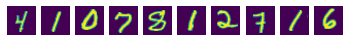

[2 0 4 8 7 6 0 6 3 1]


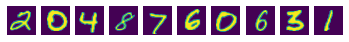

[7 8 4 4 6 5 2 9 6 6]


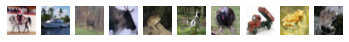

[7 0 6 9 5 1 7 0 3 2]


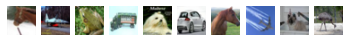

In [6]:
dataset.plot_images(MNIST_TRAIN, channels=1)
dataset.plot_images(MNIST_TEST, channels=1)
dataset.plot_images(CIFAR_TRAIN, channels=3)
dataset.plot_images(CIFAR_TEST, channels=3)

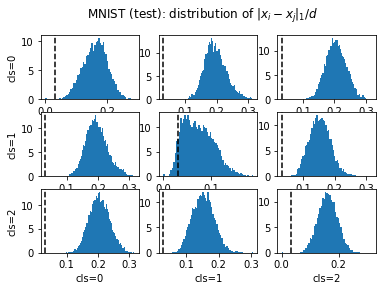

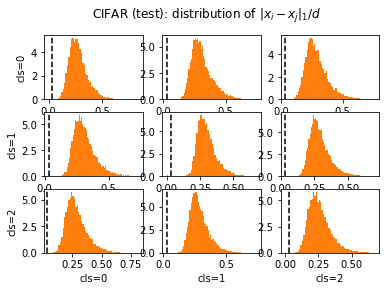

In [7]:
def plot_avg_dists(ds: dataset.Dataset, num_samples=1000, n_cls=2, eps=8/255, **plt_kwargs):
    dists = np.zeros((n_cls, n_cls, num_samples))
    for i in range(n_cls):
        for j in range(n_cls):
            xs_i = ds.xs[ds.ys == i]
            xs_j = ds.xs[ds.ys == j]
            
            idxs_i = np.random.randint(0, xs_i.shape[0], size=num_samples)
            idxs_j = np.random.randint(0, xs_j.shape[0], size=num_samples)
            
            diffs = xs_i[idxs_i] - xs_j[idxs_j]
            dists[i, j] = np.linalg.norm(diffs, ord=1, axis=-1) / diffs.shape[-1]
    
    for i in range(n_cls):
        for j in range(n_cls):
            plt.subplot(n_cls, n_cls, 1 + n_cls * i + j)
            plt.hist(dists[i, j], **plt_kwargs)
            if j == 0:
                plt.ylabel(f"cls={i}")
            if i == n_cls-1:
                plt.xlabel(f"cls={j}")
            plt.axvline(eps, color="black", linestyle="--")
                
plt.suptitle("MNIST (test): distribution of $\|x_i - x_j\|_1 / d$")
plot_avg_dists(MNIST_TEST, num_samples=10**4, bins=64, n_cls=3, density=True)
plt.show();

plt.suptitle("CIFAR (test): distribution of $\|x_i - x_j\|_1 / d$")
plot_avg_dists(CIFAR_TEST, num_samples=10**4, bins=64, n_cls=3, density=True, color="tab:orange")
plt.show();

### Experiment setup

In [13]:
def ds_prefix(ds: dataset.Dataset, sz: int) -> dataset.Dataset:
    return dataset.Dataset(
        xs=ds.xs[:sz], ys=ds.ys[:sz],
        num_classes=ds.num_classes,
        name=f"{ds.name}[:{sz}]",
    )

def subsample_ds(ds: dataset.Dataset, sz: int) -> dataset.Dataset:
    inds = np.random.choice(ds.xs.shape[0], size=sz, replace=False)
    return dataset.Dataset(
        xs=ds.xs[inds], ys=ds.ys[inds],
        num_classes=ds.num_classes,
        name=f"{ds.name}[~{sz}]",
    )

def untensor_dict(d: Dict) -> Dict:
    return {
        k: float(v) if isinstance(v, tf.Tensor) else v
        for k, v in d.items()
    }

def out_to_dict(out: Tuple, model: keras.Model, prefix: str) -> Dict:
    return untensor_dict({
        f"{prefix}_{k}" : v
        for k, v
        in zip(model.metrics_names, out)
    })

def fmt_dict(d: Dict) -> str:
    dd = {
        k: f"{v : .4f}" if isinstance(v, float) else v
        for k, v in d.items()
    }
    return str(dd)

def mlflow_log_np(a: np.ndarray, name: str):
    """name should not include .npy"""
    np.save(f"tmp-artifacts/{name}.npy", a)
    mlflow.log_artifact(f"tmp-artifacts/{name}.npy")

In [14]:
class ExperimentParams(NamedTuple):
    ds_train: dataset.Dataset
    ds_test: dataset.Dataset
    num_fourier_features: int
    kernel_scale: float
    kernel_type: str
    train_epochs: int
    adv_ratio: float  # in [0, 1]; 0 = nat. training; 1 = full adv. training
    attack_norm: Union[float, int]
    attack_eps: float
    attack_eps_step: float
    attack_iters: int
    num_eval_per_epoch: int  # How many samples to use during evaluation
    batch_size: int
    learning_rate: int
    seed: int = 42
    
    def to_mlflow_dict(self) -> Dict:
        ret = self._asdict()
        
        del ret["ds_train"]
        del ret["ds_test"]
        
        ret["ds_train_name"] = self.ds_train.name
        ret["ds_test_name"] = self.ds_test.name
        
        return ret
    
    
def run_experiment(params: ExperimentParams):
    """    
    Keras code derived from https://keras.io/examples/vision/mnist_convnet/.
    
    ART code derived from https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_retraining.ipynb
    and https://github.com/Trusted-AI/adversarial-robustness-toolbox/issues/238.
    """
    mlflow.log_params(params.to_mlflow_dict())
    np.random.seed(params.seed)
    tf.random.set_seed(params.seed)
    
    
    class ExperimentCallback(keras.callbacks.Callback):
        def on_epoch_end(self, epoch: int, logs: Dict):
            logs = untensor_dict(logs)
            print(f"Epoch {epoch} finished; Evaling...", end=" ")
            
            ds_sub_train = subsample_ds(params.ds_train, sz=params.num_eval_per_epoch)
            ds_sub_test = subsample_ds(params.ds_test, sz=params.num_eval_per_epoch)
            
            xs_sub_train_pgd = art_pgd_attack.generate(x=ds_sub_train.xs, y=ds_sub_train.ys)
            xs_sub_test_pgd = art_pgd_attack.generate(x=ds_sub_test.xs, y=ds_sub_test.ys)
            
            sub_train_nat_out = model.evaluate(ds_sub_train.xs, ds_sub_train.ys, verbose=0)
            sub_test_nat_out = model.evaluate(ds_sub_test.xs, ds_sub_test.ys, verbose=0)
            
            sub_train_pgd_out = model.evaluate(xs_sub_train_pgd, ds_sub_train.ys, verbose=0)
            sub_test_pgd_out = model.evaluate(xs_sub_test_pgd, ds_sub_test.ys, verbose=0)
            
            mlflow.log_metrics(out_to_dict(prefix="sub_train_nat", out=sub_train_nat_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_train_pgd", out=sub_train_pgd_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_test_nat", out=sub_test_nat_out, model=model))
            mlflow.log_metrics(out_to_dict(prefix="sub_test_pgd", out=sub_test_pgd_out, model=model))
            
            print(fmt_dict(logs))

    
    model : keras.Model = keras.Sequential([
        keras.layers.InputLayer(
            input_shape=params.ds_train.xs[0].shape,
        ),
        layers.experimental.RandomFourierFeatures(
            output_dim=params.num_fourier_features,
            scale=params.kernel_scale,
            kernel_initializer=params.kernel_type,
        ),
        layers.Dense(units=10),
    ])
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(learning_rate=params.learning_rate),
        metrics=["accuracy"]
    )
    

    # Wrapper around tf.keras.Model.train_step
    # Used for compatibility with art.estimators.classification.TensorFlowV2Classifier
    _sample_count = 0
    art_pgd_attack = None # Forward declaration. Hacky...
    def train_step(model, images, labels):
        nonlocal _sample_count
        nonlocal art_pgd_attack
        
        logs = model.train_step((images, labels))
        
        old_sample_count = _sample_count
        _sample_count += images.shape[0]
        
        old_epoch = old_sample_count // params.ds_train.xs.shape[0]
        cur_epoch = _sample_count // params.ds_train.xs.shape[0]
        
        if old_epoch < cur_epoch:
            ExperimentCallback().on_epoch_end(epoch=old_epoch, logs=logs)
            model.reset_metrics()
            

    art_model = TensorFlowV2Classifier(
        model=model,
        input_shape=params.ds_test.xs[0].shape,
        nb_classes=params.ds_test.num_classes,
        clip_values=(0, 1),
        loss_object=model.loss,
        train_step=train_step,
    )
    art_pgd_attack = ProjectedGradientDescent(
        art_model,
        norm=params.attack_norm,
        eps=params.attack_eps,
        eps_step=params.attack_eps_step,
        max_iter=params.attack_iters,
        batch_size=params.batch_size,
        verbose=False,
    )
    
    try: # Catch keyboard interrupt so we can exit training early
        if params.adv_ratio > 0:
            adv_trainer = AdversarialTrainer(
                art_model,
                attacks=art_pgd_attack,
                ratio=params.adv_ratio,
            )
            adv_trainer.fit(
                x=params.ds_train.xs, y=params.ds_train.ys,
                batch_size=params.batch_size,
                nb_epochs=params.train_epochs,
            )
        else:
            model.fit(
                params.ds_train.xs,
                params.ds_train.ys,
                batch_size=params.batch_size,
                epochs=params.train_epochs,
                verbose=0,
                callbacks=[ExperimentCallback()],
            )
    except KeyboardInterrupt:
        pass

    model.trainable = False
    mlflow.keras.log_model(model, "model")
    
    xs_test_pgd = art_pgd_attack.generate(x=params.ds_test.xs, y=params.ds_test.ys)
    mlflow_log_np(xs_test_pgd, "xs_test_pgd")
    
    test_nat_out = model.evaluate(params.ds_test.xs, params.ds_test.ys)
    test_pgd_out = model.evaluate(xs_test_pgd, params.ds_test.ys)
    
    mlflow.log_metrics(out_to_dict(prefix="test_nat", out=test_nat_out, model=model))
    mlflow.log_metrics(out_to_dict(prefix="test_pgd", out=test_pgd_out, model=model))
    
    preds_test_pgd = model.predict(x=xs_test_pgd, batch_size=params.batch_size).argmax(axis=-1)
    mlflow_log_np(xs_test_pgd, "preds_test_pgd")
    
    mlflow_log_np(params.ds_test.xs, "xs_test")
    mlflow_log_np(params.ds_test.ys, "ys_test")
    
    return dict(
        model=model,
        ds_test=params.ds_test,
        xs_test_pgd=xs_test_pgd,
        preds_test_pgd=preds_test_pgd,
    )

# Run experiments

### Natural training

### Adversarial training

In [19]:
EXP_PARAMS = ExperimentParams(
    ds_train=ds_prefix(CIFAR_TRAIN, 100),
    ds_test=ds_prefix(CIFAR_TEST, 100),
    num_fourier_features=4096,
    kernel_scale=1,
    kernel_type="gaussian",
    train_epochs=30,
    adv_ratio=1.0,
    attack_norm=np.inf,
    attack_eps=8.0/255,
    attack_eps_step=8.0/255/10,
    attack_iters=20,
    num_eval_per_epoch=80,  # How many samples to use during evaluation
    batch_size=32,
    learning_rate=3e-3,
    seed=42,
)

with mlflow.start_run() as _:
    res = run_experiment(EXP_PARAMS)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0 finished; Evaling... {'loss': ' 68.1643', 'accuracy': ' 0.0000'}
Epoch 1 finished; Evaling... {'loss': ' 40.6436', 'accuracy': ' 0.0000'}
Epoch 2 finished; Evaling... {'loss': ' 20.5211', 'accuracy': ' 0.0000'}
Epoch 3 finished; Evaling... {'loss': ' 13.6424', 'accuracy': ' 0.0000'}
Epoch 4 finished; Evaling... {'loss': ' 14.7455', 'accuracy': ' 0.0000'}
Epoch 5 finished; Evaling... {'loss': ' 13.0360', 'accuracy': ' 0.0000'}
Epoch 6 finished; Evaling... {'loss': ' 9.9994', 'accuracy': ' 0.0000'}
Epoch 7 finished; Evaling... {'loss': ' 8.3265', 'accuracy': ' 0.0000'}
Epoch 8 finished; Evaling... {'loss': ' 8.1452', 'accuracy': ' 0.0000'}
Epoch 9 finished; Evaling... {'loss': ' 6.9830', 'accuracy': ' 0.0000'}
Epoch 10 finished; Evaling... {'loss': ' 6.5626', 'accuracy': ' 0.0000'}
Epoch 11 finished; Evaling... {'loss': ' 5.9488', 'accuracy': ' 0.0000'}
Epoch 12 finished; Evaling... {'loss': ' 5.3766', 'accuracy': ' 0.0000'}
Epoch 13 finished; Evaling... {'loss': ' 5.3469', 'accu

INFO:tensorflow:Assets written to: /tmp/tmpxnfykcgi/model/data/model/assets


4/4 [==============================] - 0s 8ms/step - loss: 4.8204 - accuracy: 0.0000e+00


Max diff:  8.0000 / 255

[7 0 6 9 5 1 7 0 3 2]


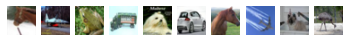

[1 3 2 2 2 3 1 2 1 1]


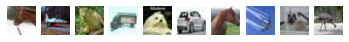

In [20]:
mx_pix_diff = np.abs(res["xs_test_pgd"] - res["ds_test"].xs).max() * 255
print(f"Max diff: {mx_pix_diff : .4f} / 255\n")

dataset.plot_images(
    dataset.Dataset(
        xs=res["ds_test"].xs,
        ys=res["ds_test"].ys,
        num_classes=10,
    ), channels=3)

dataset.plot_images(
    dataset.Dataset(
        xs=res["xs_test_pgd"],
        ys=res["preds_test_pgd"],
        num_classes=10,
    ), channels=3)